In [1]:
from definitions import create_experiment_dirs

experiment_name = 'add_columns'
experiment_dir, data_file, model_file, results_file = create_experiment_dirs(experiment_name)

In [2]:
import pandas as pd


dataset = pd.read_pickle('mydata.pkl')
y_test = pd.read_pickle('mydata_y.pkl')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10842123 entries, 0 to 10842122
Data columns (total 66 columns):
shop_id                                                                                 uint8
item_id                                                                                 uint16
date_block_num                                                                          uint8
item_cnt_month                                                                          float16
ID                                                                                      uint32
item_category_id                                                                        uint8
city_id                                                                                 uint8
category_id                                                                             uint8
subcategory_id                                                                          uint8
subsubcategory_id                  

In [4]:
dataset = dataset[dataset.date_block_num > 2]

In [5]:
stop_words = ['ID']
y_columns = ['item_cnt_month']
x_columns = [column for column in dataset.columns if (column not in y_columns) and (column not in stop_words)]

# X = df[x_columns]
# y = df[y_columns]
#
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train = dataset[dataset.date_block_num < 31][x_columns]
y_train = dataset[dataset.date_block_num < 31][y_columns]
X_val1 = dataset[dataset.date_block_num == 31][x_columns]
y_val1 = dataset[dataset.date_block_num == 31][y_columns]
X_val2 = dataset[dataset.date_block_num == 32][x_columns]
y_val2 = dataset[dataset.date_block_num == 32][y_columns]

In [6]:
# ids = dataset[dataset.date_block_num == 34]['ID']
# X_submission = dataset[dataset.date_block_num == 34][x_columns]

In [7]:
X_test = dataset[dataset.date_block_num == 33][x_columns]
# y_test = dataset[dataset.date_block_num == 33][y_columns]

In [8]:
import numpy as np

seed = 123
np.random.seed(seed)

In [9]:
from module.models.xgb import *

xgb_model = create_model(seed)

In [10]:
# fit_model(xgb_model, X_train, y_train, X_test, y_test)
xgb_model.fit(X_train, y_train, eval_set=[(X_val1, y_val1), (X_val2, y_val2)], eval_metric='rmse', verbose=True, early_stopping_rounds=10)

[01:35:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:08] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.03516	validation_1-rmse:1.13085
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.994179	validation_1-rmse:1.08276
[2]	validation_0-rmse:0.956889	validation_1-rmse:1.04503
[3]	validation_0-rmse:0.923744	validation_1-rmse:1.01321
[4]	validation_0-rmse:0.895428	validation_1-rmse:0.980708
[5]	validation_0-rmse:0.871193	validation_1-rmse:0.954553
[6]	validation_0-rmse:0.849274	validation_1-rmse:0.933844
[7]	validation_0-rmse:0.832878	validation_1-rmse:0.917619
[8]	validation_0-rmse:0.815189	validation_1-rmse:0.899162
[9]	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             silent=None, subsample=1, verbosity=1)

In [12]:
import joblib

# joblib.dump(xgb_model, model_file)
xgb_model = joblib.load(model_file)

[23:31:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [11]:
train_score = evaluate(xgb_model, X_train, y_train)
val1_score = evaluate(xgb_model, X_val1, y_val1)
val2_score = evaluate(xgb_model, X_val2, y_val2)
test_score = evaluate(xgb_model, X_test, y_test)

results = {
    'model': 'xgb',
    'train_score': train_score,
    'val1_score': val1_score,
    'val2_score': val2_score,
    'test_score': test_score,
}
print(results)

{'model': 'xgb', 'train_score': 0.7052811306597492, 'val1_score': 0.6334282504866332, 'val2_score': 0.6954469872186917, 'test_score': 0.7123221024731817}


In [14]:
Y_submission = xgb_model.predict(X_submission).clip(0, 20)

submission = pd.DataFrame({
    "ID": ids, 
    "item_cnt_month": Y_submission
})
submission.to_csv('xgb_submission.csv', index=False)

In [22]:
submission = submission.sort_values(by=['ID'])
submission.to_csv('xgb_submission.csv', index=False)
submission.head(10)

,ID,item_cnt_month
757495,0,0.098074
8913073,1,0.000000
757705,2,0.273438
1064441,3,0.014989
757873,4,0.000000
1064315,5,0.063492
757579,6,0.405869
8912737,7,0.000000
8913031,8,0.276225
757369,9,0.000000


In [15]:
import matplotlib.pyplot as plt
from xgboost import plot_importance


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

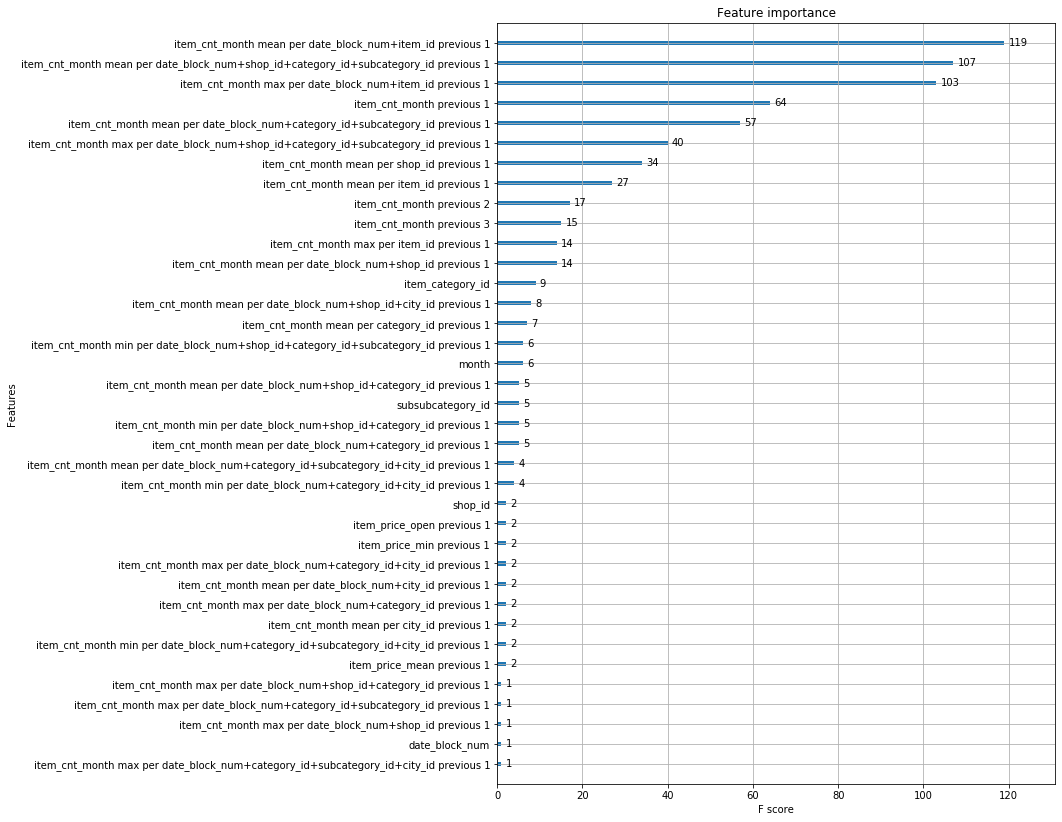

In [16]:
plot_features(xgb_model, (10,14))

In [17]:
ids.isin([np.nan, np.inf]).sum()

0

In [20]:
from module.data.read_data import test_file_processing

test = test_file_processing()

In [21]:
test.head(10)

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
5,5,5,5039,34
6,6,5,5041,34
7,7,5,5046,34
8,8,5,5319,34
9,9,5,5003,34
